Classes: ['cats', 'dogs']
Tamanho -> Train: 2000, Val: 800, Test: 200
Epoch [1/50] Train Acc: 50.55% | Val Acc: 50.00% | Train Loss: 1.0558 | Val Loss: 0.7131
Epoch [2/50] Train Acc: 50.85% | Val Acc: 53.75% | Train Loss: 0.7761 | Val Loss: 0.6939
Epoch [3/50] Train Acc: 51.70% | Val Acc: 50.38% | Train Loss: 0.7486 | Val Loss: 0.6900
Epoch [4/50] Train Acc: 54.25% | Val Acc: 49.25% | Train Loss: 0.7225 | Val Loss: 0.6985
Epoch [5/50] Train Acc: 50.05% | Val Acc: 52.38% | Train Loss: 0.7282 | Val Loss: 0.6972
Epoch [6/50] Train Acc: 54.15% | Val Acc: 48.25% | Train Loss: 0.7084 | Val Loss: 0.7114
Epoch [7/50] Train Acc: 50.45% | Val Acc: 50.00% | Train Loss: 0.7161 | Val Loss: 0.6937
Epoch [8/50] Train Acc: 50.50% | Val Acc: 55.75% | Train Loss: 0.7017 | Val Loss: 0.6876
Epoch [9/50] Train Acc: 54.80% | Val Acc: 55.00% | Train Loss: 0.6924 | Val Loss: 0.6968
Epoch [10/50] Train Acc: 56.70% | Val Acc: 60.62% | Train Loss: 0.6918 | Val Loss: 0.6711
Epoch [11/50] Train Acc: 58.15% | Val A

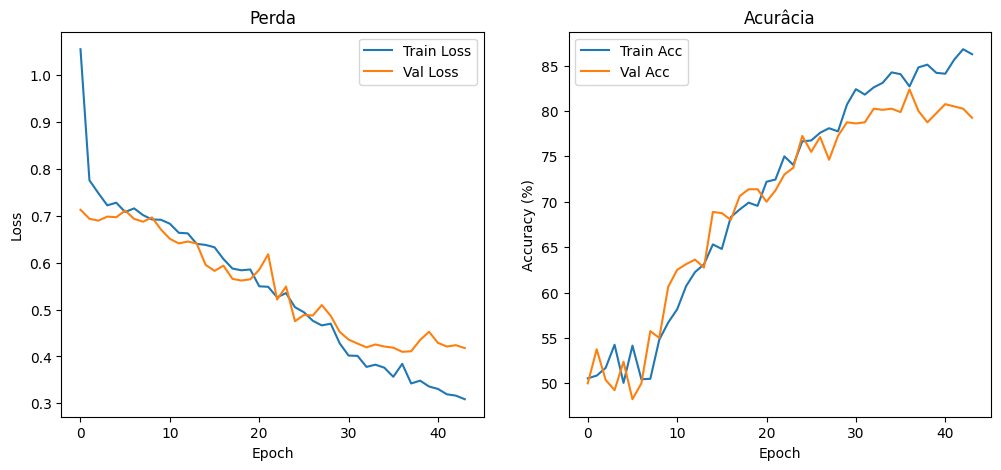

In [ ]:
# 1. Librerías
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import zipfile, requests, os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# 2. Descargar dataset Cats vs Dogs
!wget -q https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
with zipfile.ZipFile("cats_and_dogs_filtered.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

train_dir = "cats_and_dogs_filtered/train"
val_dir   = "cats_and_dogs_filtered/validation"

# 3. Transformaciones con Data Augmentation
img_size = 224
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
    transforms.RandomErasing(p=0.2)  # Cutout
])

val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

# 4. Datasets y loaders
full_val_ds = datasets.ImageFolder(val_dir, transform=val_transform)

# Dividir validation en val (80%) y test (20%)
val_size = int(0.8 * len(full_val_ds))  # 800 imágenes
test_size = len(full_val_ds) - val_size # 200 imágenes
val_ds, test_ds = torch.utils.data.random_split(full_val_ds, [val_size, test_size])

train_ds = datasets.ImageFolder(train_dir, transform=train_transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

print("Classes:", train_ds.classes)
print(f"Tamanho -> Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")


# 5. Definición de MobileNetV1
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3,
                                   stride=stride, padding=1, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1,
                                   stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = F.relu6(self.bn1(self.depthwise(x)))
        x = F.relu6(self.bn2(self.pointwise(x)))
        return x

class MobileNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)

        self.dw_conv2 = DepthwiseSeparableConv(32, 64, 1)
        self.dw_conv3 = DepthwiseSeparableConv(64, 128, 2)
        self.dw_conv4 = DepthwiseSeparableConv(128, 128, 1)
        self.dw_conv5 = DepthwiseSeparableConv(128, 256, 2)
        self.dw_conv6 = DepthwiseSeparableConv(256, 256, 1)
        self.dw_conv7 = DepthwiseSeparableConv(256, 512, 2)

        self.dw_conv8  = DepthwiseSeparableConv(512, 512, 1)
        self.dw_conv9  = DepthwiseSeparableConv(512, 512, 1)
        self.dw_conv10 = DepthwiseSeparableConv(512, 512, 1)
        self.dw_conv11 = DepthwiseSeparableConv(512, 512, 1)
        self.dw_conv12 = DepthwiseSeparableConv(512, 512, 1)

        self.dw_conv13 = DepthwiseSeparableConv(512, 1024, 2)
        self.dw_conv14 = DepthwiseSeparableConv(1024, 1024, 1)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.5)   # más fuerte
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = F.relu6(self.bn1(self.conv1(x)))
        x = self.dw_conv2(x)
        x = self.dw_conv3(x)
        x = self.dw_conv4(x)
        x = self.dw_conv5(x)
        x = self.dw_conv6(x)
        x = self.dw_conv7(x)
        x = self.dw_conv8(x)
        x = self.dw_conv9(x)
        x = self.dw_conv10(x)
        x = self.dw_conv11(x)
        x = self.dw_conv12(x)
        x = self.dw_conv13(x)
        x = self.dw_conv14(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# 6. Entrenamiento con RMSProp, EarlyStopping y LR Scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MobileNet(num_classes=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-4, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3)

EPOCHS = 50
patience = 7
best_val_loss = np.inf
counter = 0

history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}

for epoch in range(EPOCHS):
    # Entrenamiento
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100.0 * correct / total

    # Validación
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100.0 * val_correct / val_total

    scheduler.step(val_loss)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% "
          f"| Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "mobilenetv1_best.pth")
    else:
        counter += 1
        if counter >= patience:
            print("⏹️ Early stopping activado.")
            break

# 7. Información del modelo
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nParâmetros totais: {total_params:,}")
print(f"Parâmetros treináveis: {trainable_params:,}")

torch.save(model.state_dict(), "mobilenetv1_best.pth")
size_kb = os.path.getsize("mobilenetv1_best.pth") / 1024
print(f"Tamanho do modelo guardado: {size_kb:.2f} KB")

# 8. Graficar resultados
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Perda")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.title("Acurâcia")
plt.legend()
plt.show()

Exemplos


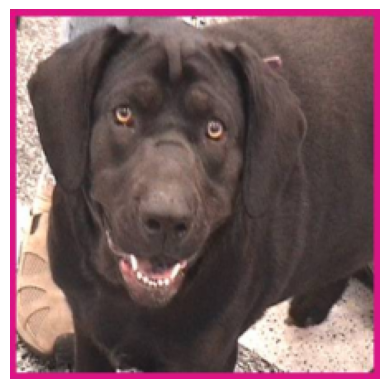

Label Real: dogs | Label Modelo: cats



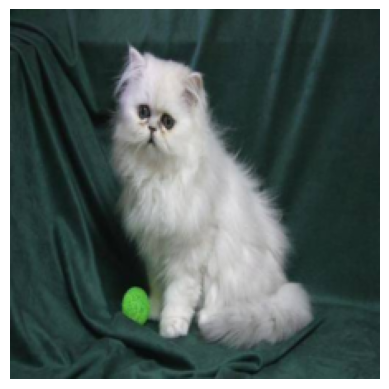

Label Real: cats | Label Modelo: cats



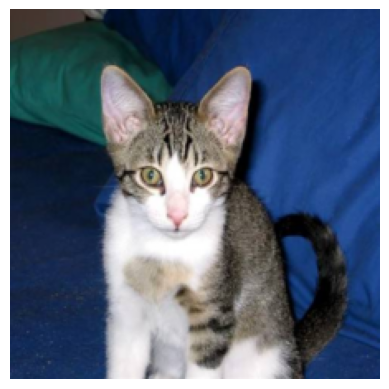

Label Real: cats | Label Modelo: cats



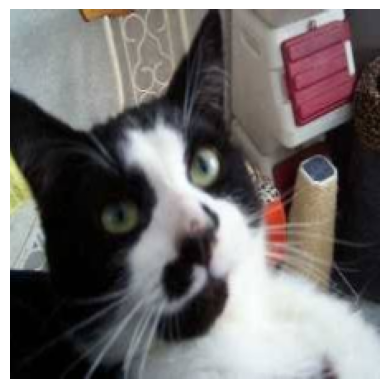

Label Real: cats | Label Modelo: cats



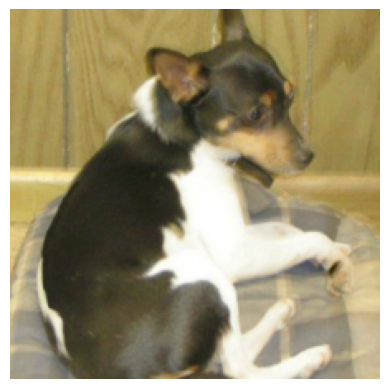

Label Real: dogs | Label Modelo: cats



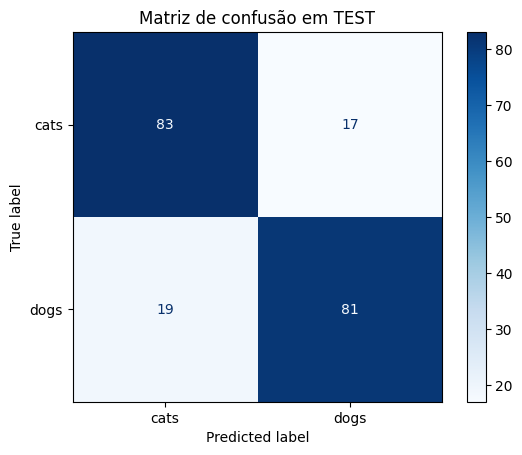

Acurâcia em todo o conjunto de TEST: 82.00%


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 9A. Predicción en 5 imágenes de validación aleatorias
import random

def predict_from_dataset(dataset, model, class_names, n=5):
    model.eval()
    indices = random.sample(range(len(dataset)), n)
    for idx in indices:
        img, label = dataset[idx]
        plt.imshow(img.permute(1, 2, 0).numpy() * 0.5 + 0.5)  # desnormalizar
        plt.axis("off")
        plt.show()

        img_t = img.unsqueeze(0).to(device)
        with torch.no_grad():
            outputs = model(img_t)
            _, pred = outputs.max(1)
        print(f"Label Real: {class_names[label]} | Label Modelo: {class_names[pred.item()]}\n")

print("Exemplos")
predict_from_dataset(val_ds, model, train_ds.classes, n=5)


# 9B. Evaluación completa en el set de TEST
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Matriz de confusión en TEST
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de confusão em TEST")
plt.show()

# Accuracy global en TEST
test_accuracy = (np.array(y_true) == np.array(y_pred)).mean() * 100
print(f"Acurâcia em todo o conjunto de TEST: {test_accuracy:.2f}%")
